# Hydrological Flood Detection – **v4** (Per‑Station XGBoost)
*Generated 2025-08-06 23:35*

Trains one XGBoost model per station using rainfall windows, discharge lags, rate-of-change, and 7‑day antecedent precipitation (API7). Floods are labelled as discharge above the 92‑percentile for each station.

In [1]:
# Auto-install required packages if missing
import importlib, subprocess, sys, warnings
for pkg in ['xgboost']:
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd, numpy as np
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, average_precision_score
import joblib, datetime, os

# CONFIG
PROJECT_ROOT = Path.cwd() if (Path.cwd()/'data').exists() else Path.cwd().parent
DATA_RAW = PROJECT_ROOT/'data'/'raw'
STATIONS = ['D08A071','D08A084','D08A115']
ROLL_WINDOWS = [3,6,12]
LAG_HRS = range(1,13)
PERCENTILE = 0.92
TEST_FRAC = 0.2
API_WINDOW = 24*7
RANDOM_SEED = 42


In [3]:
def find_csv(code):
    p = DATA_RAW / f'station_{code}'
    files = list(p.glob('*.csv'))
    assert len(files)==1, f'{code}: expected 1 csv'
    return files[0]

def load_station(code):
    df = pd.read_csv(find_csv(code))
    df['datetime'] = pd.to_datetime(df['saatlik'])
    df = (df.rename(columns={'yagis_toplam':'rain_mm','qdeger':'discharge_cms'})
            .set_index('datetime').sort_index()
            .resample('h')
            .agg({'rain_mm':'sum','discharge_cms':'mean'}))
    df['station'] = code
    return df


In [10]:
# Load all stations
frames = [load_station(c) for c in STATIONS]
full   = pd.concat(frames, keys=STATIONS, names=['station','datetime'])
print('Shape:', full.shape)


Shape: (251649, 3)


In [ ]:
def build_features(df):
    st = df.copy()
    for w in ROLL_WINDOWS:
        st[f'rain_sum_{w}h'] = st['rain_mm'].rolling(w, min_periods=1).sum()
    for l in LAG_HRS:
        st[f'dis_lag_{l}h'] = st['discharge_cms'].shift(l)
    st['dis_rate_1h'] = st['discharge_cms'].diff(1)
    st['dis_rate_3h'] = st['discharge_cms'].diff(3)
    st['API7'] = st['rain_mm'].rolling(API_WINDOW, min_periods=1).sum()
    st.dropna(inplace=True)
    print('After FE:', )
    thr = st['discharge_cms'].quantile(PERCENTILE)
    st['flood'] = (st['discharge_cms'] > thr).astype(int)
    return st


In [5]:
feature_cols_global = None
reports = []
models = {}
os.makedirs(PROJECT_ROOT/'models/per_station', exist_ok=True)

for code in STATIONS:
    df_raw = load_station(code)
    df = build_features(df_raw)
    feature_cols = [c for c in df.columns if c.startswith(('rain_sum','dis_lag','dis_rate','API'))]
    feature_cols_global = feature_cols
    split = int(len(df)*(1-TEST_FRAC))
    X_tr, X_te = df.iloc[:split][feature_cols], df.iloc[split:][feature_cols]
    y_tr, y_te = df.iloc[:split]['flood'], df.iloc[split:]['flood']
    neg, pos = np.bincount(y_tr)
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='aucpr',
        learning_rate=0.05,
        n_estimators=800,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_SEED,
        scale_pos_weight=neg/pos,
        n_jobs=-1,
    )
    model.fit(X_tr, y_tr)
    models[code] = model
    joblib.dump(model, PROJECT_ROOT/f'models/per_station/xgb_{code}_{datetime.date.today()}.pkl')
    y_prob = model.predict_proba(X_te)[:,1]
    y_pred = (y_prob>0.5).astype(int)
    rpt = classification_report(y_te, y_pred, output_dict=True)
    pr_auc = average_precision_score(y_te, y_prob)
    reports.append({
        'station':code,
        'precision':round(rpt['1']['precision'],3),
        'recall':round(rpt['1']['recall'],3),
        'f1':round(rpt['1']['f1-score'],3),
        'PR-AUC':round(pr_auc,3),
        'test_flood_hours':int(y_te.sum())
    })

summary = pd.DataFrame(reports).set_index('station')
summary


,precision,recall,f1,PR-AUC,test_flood_hours
station,,,,,
D08A071,0.99,1.000,0.995,1.000,497
D08A084,1.00,0.998,0.999,1.000,524
D08A115,1.00,0.941,0.970,0.997,17


In [14]:
summary_rows = []

for code in STATIONS:
    # If you cached frames in station_frames dict, use that to avoid re-reading:
    # df_fe = station_frames[code]
    df_raw = load_station(code)
    df_fe  = build_features(df_raw.copy())

    split = int(len(df_fe)*(1-TEST_FRAC))
    train_sz = split
    test_sz  = len(df_fe) - split

    flood_dist = df_fe['flood'].value_counts().to_dict()

    summary_rows.append({
        'station': code,
        'raw_shape': df_raw.shape,
        'after_FE_shape': df_fe.shape,
        'flood_distribution': flood_dist,
        'train_size': train_sz,
        'test_size': test_sz
    })

pd.DataFrame(summary_rows).set_index('station')

After FE:                      rain_mm  discharge_cms  station  rain_sum_3h  \
datetime                                                            
2014-01-01 12:00:00      0.0          0.683  D08A071          0.0   
2014-01-01 13:00:00      0.0          0.683  D08A071          0.0   
2014-01-01 14:00:00      0.0          0.683  D08A071          0.0   
2014-01-01 15:00:00      0.0          0.683  D08A071          0.0   
2014-01-01 16:00:00      0.0          0.683  D08A071          0.0   
...                      ...            ...      ...          ...   
2024-12-31 19:00:00      0.0          6.244  D08A071          0.0   
2024-12-31 20:00:00      0.0          6.244  D08A071          0.0   
2024-12-31 21:00:00      0.0          6.244  D08A071          0.0   
2024-12-31 22:00:00      0.0          6.244  D08A071          0.0   
2024-12-31 23:00:00      0.0          6.244  D08A071          0.0   

                     rain_sum_6h  rain_sum_12h  dis_lag_1h  dis_lag_2h  \
datetime          

,raw_shape,after_FE_shape,flood_distribution,train_size,test_size
station,,,,,
D08A071,"(96432, 3)","(25551, 22)","{0: 23693, 1: 1858}",20440,5111
D08A084,"(77587, 3)","(31967, 22)","{0: 29479, 1: 2488}",25573,6394
D08A115,"(77630, 3)","(21941, 22)","{0: 20212, 1: 1729}",17552,4389


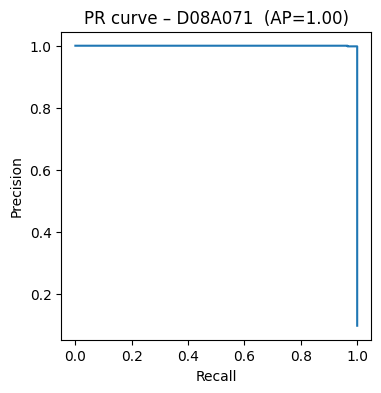

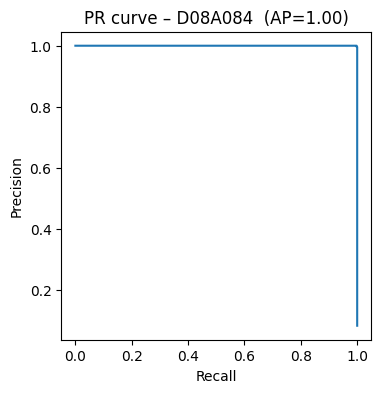

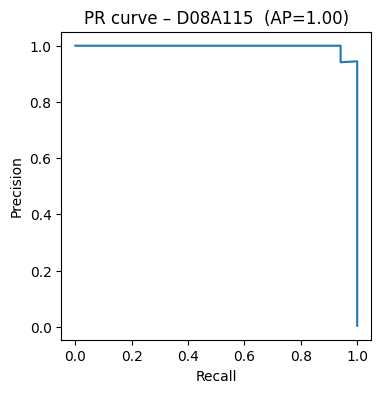

Threshold sweep (first rows):


,station,thr,precision,recall
0,D08A071,0.0,0.097,1.0
1,D08A071,0.0,0.097,1.0
2,D08A071,0.0,0.097,1.0
3,D08A071,0.0,0.097,1.0
4,D08A071,0.0,0.097,1.0
5,D08A071,0.0,0.100,1.0
6,D08A071,0.0,0.100,1.0
7,D08A071,0.0,0.102,1.0
8,D08A071,0.0,0.102,1.0
9,D08A071,0.0,0.102,1.0


In [7]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

sweep_rows = []

for code, model in models.items():
    # --- recreate feature frame for this station ---
    df = build_features(load_station(code))

    # same train/test split as before
    split = int(len(df)*(1-TEST_FRAC))
    X_te = df.iloc[split:][feature_cols_global]
    y_te = df.iloc[split:]['flood']
    y_prob = model.predict_proba(X_te)[:,1]

    # PR metrics
    prec, rec, thr = precision_recall_curve(y_te, y_prob)
    ap   = average_precision_score(y_te, y_prob)

    # store first 15 rows of sweep
    for p,r,t in zip(prec[:15], rec[:15], thr[:15]):
        sweep_rows.append({'station':code,
                           'thr': round(float(t),4),
                           'precision': round(p,3),
                           'recall': round(r,3)})

    # PR curve
    plt.figure(figsize=(4,4))
    plt.plot(rec, prec)
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title(f'PR curve – {code}  (AP={ap:.2f})')
    plt.show()

sweep_df = pd.DataFrame(sweep_rows)
print("Threshold sweep (first rows):")
sweep_df.head(20)

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

y_true_all, y_pred_all = [], []

for code, model in models.items():
    df = build_features(load_station(code))
    split = int(len(df)*(1-TEST_FRAC))
    X_te = df.iloc[split:][feature_cols_global]
    y_te = df.iloc[split:]['flood']
    y_prob = model.predict_proba(X_te)[:,1]
    y_pred = (y_prob > 0.50).astype(int)

    y_true_all.append(y_te)
    y_pred_all.append(pd.Series(y_pred, index=y_te.index))

y_true_all = pd.concat(y_true_all)
y_pred_all = pd.concat(y_pred_all)

print("OVERALL accuracy :", round(accuracy_score(y_true_all, y_pred_all),3))
print("OVERALL precision:", round(precision_score(y_true_all, y_pred_all),3))
print("OVERALL recall   :", round(recall_score(y_true_all, y_pred_all),3))
print("OVERALL confusion matrix:\n", confusion_matrix(y_true_all, y_pred_all))

OVERALL accuracy : 1.0
OVERALL precision: 0.995
OVERALL recall   : 0.998
OVERALL confusion matrix:
 [[14851     5]
 [    2  1036]]
